In [1]:
import pickle 
import matplotlib.pyplot as plt 
import numpy as np
import pickle 

In [2]:
"""

Purpose of this script: We want to augment our training data for faces in Human dataset (from Adobe).
But the faces in Human have much large variances in terms of orientation, and commonly used faces such as 
from celeba and ffhq, they are mostly front facing. Thus in order to solve this domain gap, we fire a 
HeadPoseEstimator (https://github.com/Yuheng-Li/HeadPoseEstimation) to get all faces orientations in three 
directions, yaw, pitch and roll (which are marginal dists along three directions) and then further divide into
multiple ranges. For example, if you divide into 5 for each directions, then you approximate head orientation
using 5*5*5=125 categories. 

Given your target dist (which is from Human) and your current available data (say from Celeba), you want to 
know what should be a multiplier for each category such that multiplied data has the same dist as target dist.
For example, say in your human dataset, there are many left facing images, thus you want to multiply a big number 
to left facing category in celeba such that each categories have the same sampling probabilities.

This script will output multipliers 

"""

'\n\nPurpose of this script: We want to augment our training data for faces in Human dataset (from Adobe).\nBut the faces in Human have much large variances in terms of orientation, and commonly used faces such as \nfrom celeba and ffhq, they are mostly front facing. Thus in order to solve this domain gap, we fire a \nHeadPoseEstimator (https://github.com/Yuheng-Li/HeadPoseEstimation) to get all faces orientations in three \ndirections, yaw, pitch and roll (which are marginal dists along three directions) and then further divide into\nmultiple ranges. For example, if you divide into 5 for each directions, then you approximate head orientation\nusing 5*5*5=125 categories. \n\nGiven your target dist (which is from Human) and your current available data (say from Celeba), you want to \nknow what should be a multiplier for each category such that multiplied data has the same dist as target dist.\nFor example, say in your human dataset, there are many left facing images, thus you want to mu

In [3]:
# Note that opened pkl fils are from: https://github.com/Yuheng-Li/HeadPoseEstimation

In [4]:
with open('celeba_result.pkl', 'rb') as fp:
    result = pickle.load(fp)
name_celeba = result['file_name']
yaw_celeba = result['yaw']
pitch_celeba = result['pitch']
roll_celeba = result['roll']

In [5]:
# zipped = zip(roll, yaw, pitch, file_name)
# roll, yaw, pitch, file_name = zip(*sorted(zipped))

(2.012744594065348, 15.598688507086498)

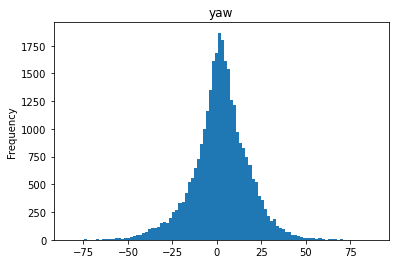

In [6]:
plt.hist(yaw_celeba, bins=100)
plt.gca().set(title='yaw', ylabel='Frequency')

np.mean(yaw_celeba), np.std( yaw_celeba  )

(-0.13661260096232097, 2.5737075122011865)

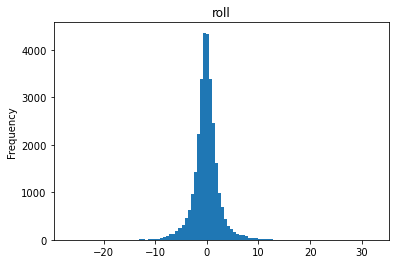

In [7]:
plt.hist(roll_celeba, bins=100)
plt.gca().set(title='roll', ylabel='Frequency');

np.mean(roll_celeba), np.std( roll_celeba  )

(-7.136896704483032, 8.107060884322637)

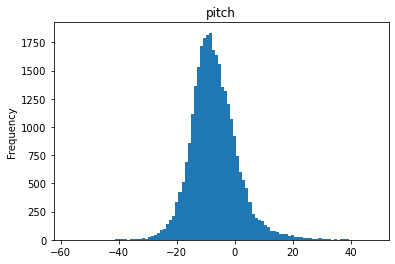

In [8]:
plt.hist(pitch_celeba, bins=100)
plt.gca().set(title='pitch', ylabel='Frequency')

np.mean(pitch_celeba), np.std( pitch_celeba  )

In [10]:
with open('human_result.pkl', 'rb') as fp:
    result = pickle.load(fp)
name_human = result['file_name']
yaw_human = result['yaw']
pitch_human = result['pitch']
roll_human = result['roll']

(3.062658054455531, 22.199318610596787)

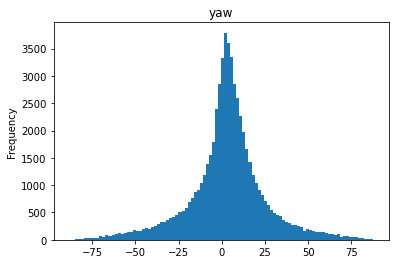

In [11]:
plt.hist(yaw_human, bins=100)
plt.gca().set(title='yaw', ylabel='Frequency')

np.mean(yaw_human), np.std( yaw_human  )

(-1.039953303891194, 12.653393794369336)

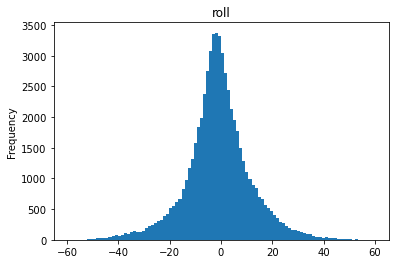

In [12]:
plt.hist(roll_human, bins=100)
plt.gca().set(title='roll', ylabel='Frequency')

np.mean(roll_human), np.std( roll_human  )

(-4.811083472734913, 11.619886388696655)

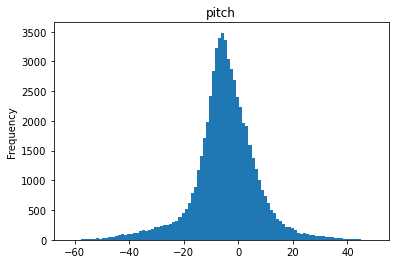

In [13]:
plt.hist(pitch_human, bins=100)
plt.gca().set(title='pitch', ylabel='Frequency')

np.mean(pitch_human), np.std( pitch_human  )

In [ ]:
# # # # # # # # # # Now Let's get dist for each dataset # # # # # # # # # #

In [14]:
def which_split(x, split):
    for i, small_range in enumerate(split):
        if   small_range[0] <= x <= small_range[1]:
            return i 

In [15]:
def draw_bar(dist):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    xxx = range(len(dist))
    yyy = dist
    ax.bar(xxx, yyy)
    plt.show()

In [16]:
def get_distribution( yaw_split, roll_split, pitch_split, yaws, rolls, pitchs, names ):
    
    combination = len(yaw_split)*len(roll_split)*len(pitch_split)
    dist = np.zeros(combination)
    
    combination_types = {}  # key is index, value is split combination  
    combination_names = {}  # key is index, value is image file names  
    location = {}
    count = 0     
    for i, yaw_range in enumerate(yaw_split):
        for j, roll_range in enumerate(roll_split):
            for k, pitch_range in enumerate(pitch_split):
                combination_types[count] = {'yaw_range':yaw_range, 'roll_range':roll_range, 'pitch_range':pitch_range}
                combination_names[count] = [] 
                location[ (i,j,k) ] = count
                count+=1 
                
                                                
    for yaw, roll, pitch, name in zip(yaws, rolls, pitchs, names):  
        
        which_yaw = which_split(yaw, yaw_split)
        which_roll = which_split(roll, roll_split)
        which_pitch = which_split(pitch, pitch_split)
        idx = location[ (which_yaw,which_roll,which_pitch) ]
        
        dist[idx] += 1
        combination_names[idx].append( name )
        
    return dist, dist/len(yaws), combination_types, combination_names

In [17]:
# split according to mean and std from celeba  
# (-90,mu-2sigma), (mu-2sigma, mu-sigma), (mu-sigma,mu+sigma), (mu+sigma,mu+2sigma), (mu+sigma,90)

# You can also split according to Human dist, but we already know that human dataset has larger variance
# so even one range may include almost all data from Celeba, for example if you use mu and sigma from human then 
# almost all data from celeba will fall into (mu-sigma, mu+sigma). However if you use mu and sigma from celeba, 
# it can reflect the 'noisiness' of Human dataset as we use smaller variance from celeba. 


yaw_split = [ [-90,-28],
              [-28,-13],
              [-13, 17],
              [-17, 32],
              [ 17, 90] ] 

roll_split = [[-90,  -5],
              [ -5,  -2.5],
              [-2.5,  2.5],
              [ 2.5,  5],
              [ 5,    90]] 


pitch_split = [[-90, -23],
               [-23, -15],
               [-15,   1],
               [  1,  9 ], 
               [  9,  90]]

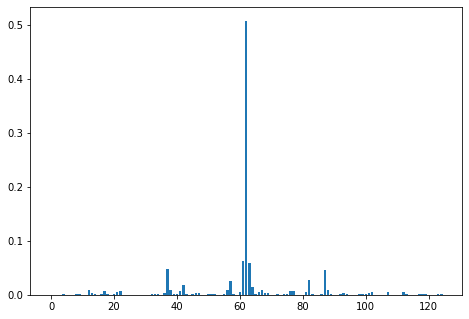

In [19]:
count_celeba, dist_celeba, combination_type, combination_name = get_distribution( yaw_split, roll_split, pitch_split, yaw_celeba, roll_celeba, pitch_celeba, name_celeba )
draw_bar(dist_celeba)

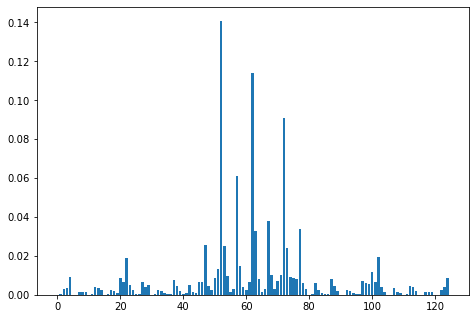

In [20]:
# combination_type is same so do not need to output, we do not need to sample data from Human, thus combination_name is not needed 
count_human, dist_human, _, _ = get_distribution( yaw_split, roll_split, pitch_split, yaw_human, roll_human, pitch_human, name_human )
draw_bar(dist_human)

In [ ]:
# From above dist visulization, we can see that Human data as more 'noises' in the standard of celeba

In [ ]:
# # # # # # # # # # # # # # Calculate multiplers # # # # # # # # # # # # # # 

In [21]:
def get_sample_stats( dist_human, count_image  ):
    
    """
    dist_human: from get_distribution(), it shows how does Human dist look like in the other dataset
    count_image: from get_distribution(), this should be stats from dataset you want to sample, such as Celeba.
    
    It will first find the 'best cause category'. For example your count_image is [8000,4000,2000,50000]
    and your asked dist is [0.3, 0.4, 0.1, 0.2]. Then you can see that the last one is the best case, as it
    has enough data to do sampling (wo replacement) according to the dist above. 
   
    Then it will calculate multiplier for each category. For example the firt_ratio / best_ratio = 0.3/0.2=1.5
    which means you ask the first category should have had 1.5 times data than the last one, 
    thus it needs a multiplier: 1.5*50000 / 8000    
    """
    
    best_idx = 0
    
    for i in range(  len(dist_human)  ):
        data_ratio = (count_image[i]+1) / (count_image[best_idx]+1)  # +1 for safe 
        dist_ratio = dist_human[i] / dist_human[best_idx]
        
        if data_ratio>dist_ratio:
            best_idx = i
            
    print('best idx is', best_idx)
            
            
    best_ratio = dist_human[best_idx]
    best_count = count_image[best_idx]
    
  
    multipliers = np.zeros( len(dist_human) )
    for i in range(  len(dist_human)  ):
        idea_data_count = dist_human[i] / best_ratio * best_count
        if count_image[i] != 0:
            multipliers[i] = idea_data_count / count_image[i]
        
    return multipliers

In [23]:
categories_multiplier = get_sample_stats(dist_human, count_celeba)
categories_multiplier = np.rint(categories_multiplier)

best idx is 81


In [24]:
# Let's broadcast multipliers into each images for each categoris (so it can be used in SceneGAN code)

each_image_multipliers = { key: None for key in name_celeba} 

for category_idx in combination_name.keys():
    
    this_category_multipler = categories_multiplier[category_idx]
    
    # then find all images belonging to this category
    images = combination_name[category_idx]
    for image in images:
        each_image_multipliers[image] = this_category_multipler
        
# only fetch values and save this list 
each_image_multipliers = list(each_image_multipliers.values())
with open('celeba_multipliers.pkl', "wb") as fp:  
    pickle.dump(each_image_multipliers, fp)

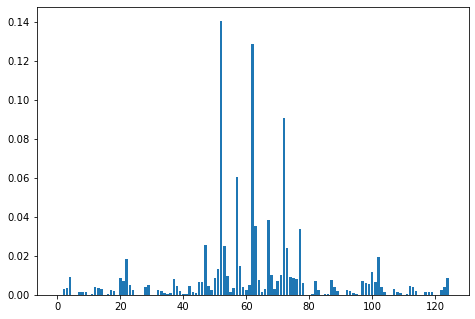

In [25]:
# In order to verify, we duplicate each images accorinding to each_image_multipliers and see dist 


def duplicate( list1, list2  ):
    out = []
    for item, frenquency in zip(list1, list2):
        out += [item]*int(frenquency)
    return out


name_celeba_modified = duplicate( name_celeba, each_image_multipliers )
yaw_celeba_modified = duplicate( yaw_celeba, each_image_multipliers )
pitch_celeba_modified = duplicate( pitch_celeba, each_image_multipliers )
roll_celeba_modified = duplicate( roll_celeba, each_image_multipliers )


# use the same split (from celeba) and see what does modified celeba looks like 
_, dist_celeba_modified, _, _ = get_distribution( yaw_split, roll_split, pitch_split, yaw_celeba_modified, roll_celeba_modified, pitch_celeba_modified, name_celeba_modified )
draw_bar(dist_celeba_modified)


In [ ]:
# Looks like same as Human dataset, then this modifed dist should be safe to use

In [ ]:
# Do the same thing for FFHQ

In [26]:
with open('ffhq_result.pkl', 'rb') as fp:
    orientation_result = pickle.load(fp)
name_ffhq = orientation_result['file_name']
yaw_ffhq = orientation_result['yaw']
pitch_ffhq = orientation_result['pitch']
roll_ffhq = orientation_result['roll']

(2.012744594065348, 15.598688507086498)

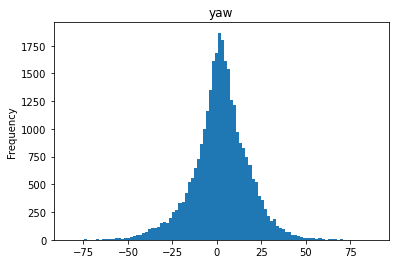

In [27]:
plt.hist(yaw_celeba, bins=100)
plt.gca().set(title='yaw', ylabel='Frequency')

np.mean(yaw_celeba), np.std( yaw_celeba  )

(-0.13661260096232097, 2.5737075122011865)

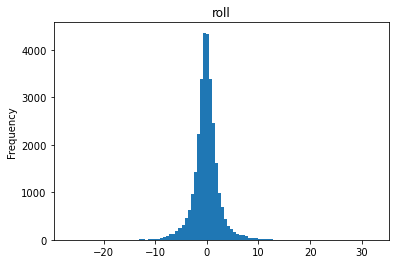

In [28]:
plt.hist(roll_celeba, bins=100)
plt.gca().set(title='roll', ylabel='Frequency');

np.mean(roll_celeba), np.std( roll_celeba  )

(-7.136896704483032, 8.107060884322637)

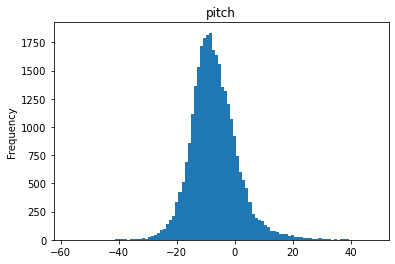

In [29]:
plt.hist(pitch_celeba, bins=100)
plt.gca().set(title='pitch', ylabel='Frequency')

np.mean(pitch_celeba), np.std( pitch_celeba  )

In [ ]:
# You can see that FFHQ and CelebA shares the same marginal distribution (mu and sigma).
# so we can use the same split 

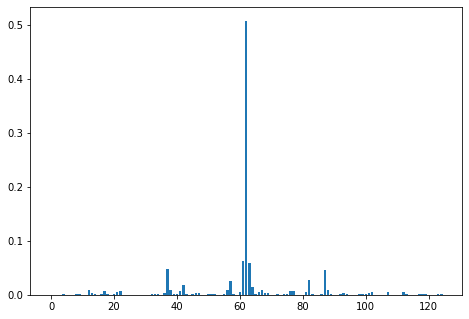

In [30]:
count_ffhq, dist_ffhq, _, combination_name = get_distribution( yaw_split, roll_split, pitch_split, yaw_ffhq, roll_ffhq, pitch_ffhq, name_ffhq )
draw_bar(dist_celeba)

In [31]:
categories_multiplier = get_sample_stats(dist_human, count_ffhq)
categories_multiplier = np.rint(categories_multiplier)

best idx is 37


In [32]:
# Let's broadcast multipliers into each images for each categoris (so it can be used in SceneGAN code)

each_image_multipliers = { key: None for key in name_ffhq} 

for category_idx in combination_name.keys():
    
    this_category_multipler = categories_multiplier[category_idx]
    
    # then find all images belonging to this category
    images = combination_name[category_idx]
    for image in images:
        each_image_multipliers[image] = this_category_multipler
        
# only fetch values and save this list 
each_image_multipliers = list(each_image_multipliers.values())
with open('ffhq_multipliers.pkl', "wb") as fp:  
    pickle.dump(each_image_multipliers, fp)